In [1]:
# digit recognizer 0 to 9 using mnist Dataset

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import torch
import torch.nn as nn
import torch.cuda
import torchvision.datasets as datasets
import time

In [3]:
# MNIST = datasets.mnist('data.csvmnist_trainset')
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [5]:
X_train = mnist_trainset.data.to(device)
X_train = X_train.float()

y_train = mnist_trainset.targets.to(device)

X_test = mnist_testset.data.to(device)
X_test = X_test.float()

y_test = mnist_testset.targets.to(device)

X_train

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0., 

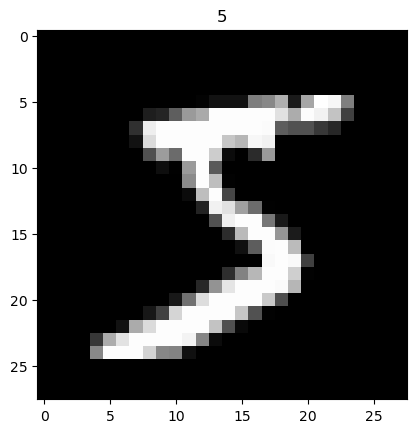

In [6]:
def show_img(data: torch.Tensor, label: torch.Tensor, rows=1, columns=1):
    fig, axs = plt.subplots(rows, columns)
    plt.imshow(torch.Tensor.cpu(data).reshape(28,28,-1) , cmap='grey')
    plt.title(label.item())
    plt.show()
    
show_img(X_train[0],y_train[0])

In [7]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 10)
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        output = input.view(-1, 28*28)
        output = self.l1(output)
        output = self.relu(output)
        output = self.l2(output)
        output = self.relu(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [21]:
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.l1 = nn.Linear(input_size, hidden_size1)
        self.l2 = nn.Linear(hidden_size1, hidden_size2)
        self.l3 = nn.Linear(hidden_size2, 10)
        self.dropout = nn.Dropout(0.2)
        
        self.relu = nn.ReLU()
        self.sig = nn.Sigmoid()

    def forward(self, input: torch.Tensor):
        input = input.view(-1, 1, 28, 28)
        output = self.relu(self.pool(self.conv1(input)))
        output = self.relu(self.pool(self.conv2(output)))

        output = output.view(-1, 16 * 4*4)

        output = self.dropout(output)
        output = self.l1(output)
        output = self.relu(output)
        output = self.dropout(output)
        output = self.l2(output)
        output = self.relu(output)
        output = self.l3(output)
        output = self.sig(output)
        return output

In [23]:
for i in range(5):
    epochs = 200
    learning_rate = 0.0005
    # model = Model(28*28, 40, 20).to(device)
    model = Model2(4*4*16, 40, 20).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    start_time = time.time()
    for i in range(epochs):
        pred = model(X_train)
        loss = criterion(pred, y_train)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(i % (epochs//20)==0):
            with torch.no_grad():
                pred_test = model(X_test)
                pred_test = torch.argmax(pred_test, dim=1)
            
                correct = (pred_test==y_test).sum().item()
                acc = 100 * (correct/y_test.size(dim=0))
                print(f'{i}/{epochs}')
                print(f'loss = {loss.item():.3f}')
                print(f'accuracy = {acc:.3f}', end=2*'\n')
                
    with torch.no_grad():
        pred_test = model(X_test)
        pred_test = torch.argmax(pred_test, dim=1)
    
        correct = (pred_test==y_test).sum().item()
        acc = 100 * (correct/y_test.size(dim=0))
        print(f'{i}/{epochs}')
        print(f'loss = {loss.item():.3f}')
        print(f'accuracy = {acc:.3f}', end=2*'\n')
        
    end_time = time.time()
    print(f'total {end_time-start_time:.3f} seconds on {device}.')

0/200
loss = 2.354
accuracy = 11.310

10/200
loss = 2.142
accuracy = 26.440

20/200
loss = 1.986
accuracy = 41.770

30/200
loss = 1.880
accuracy = 51.030

40/200
loss = 1.802
accuracy = 60.500

50/200
loss = 1.735
accuracy = 67.560

60/200
loss = 1.688
accuracy = 74.350

70/200
loss = 1.651
accuracy = 79.580

80/200
loss = 1.624
accuracy = 83.730

90/200
loss = 1.599
accuracy = 87.170

100/200
loss = 1.577
accuracy = 89.250

110/200
loss = 1.560
accuracy = 91.000

120/200
loss = 1.548
accuracy = 91.820

130/200
loss = 1.540
accuracy = 92.940

140/200
loss = 1.534
accuracy = 92.720

150/200
loss = 1.528
accuracy = 93.240

160/200
loss = 1.524
accuracy = 93.650

170/200
loss = 1.520
accuracy = 94.200

180/200
loss = 1.517
accuracy = 94.390

190/200
loss = 1.514
accuracy = 94.810

199/200
loss = 1.513
accuracy = 95.010

total 171.485 seconds on cuda.
0/200
loss = 2.378
accuracy = 13.660

10/200
loss = 2.166
accuracy = 25.910

20/200
loss = 2.017
accuracy = 38.310

30/200
loss = 1.908
accu

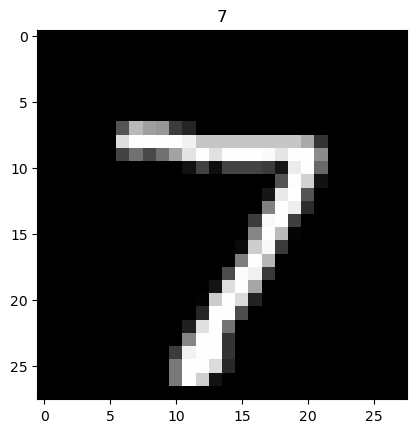

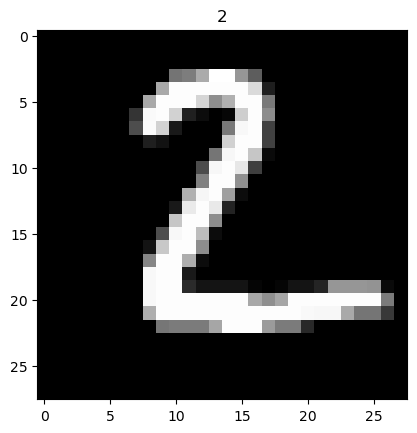

In [17]:
for i in range(2): # visualizing model's performance
    show_img(X_test[i], pred_test[i])

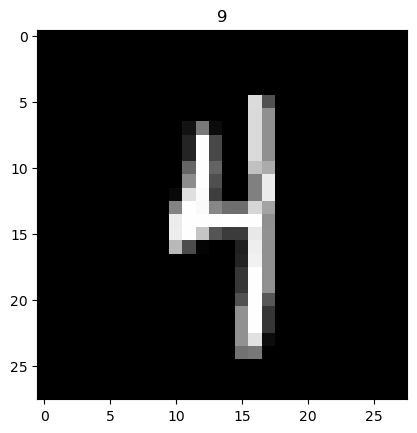

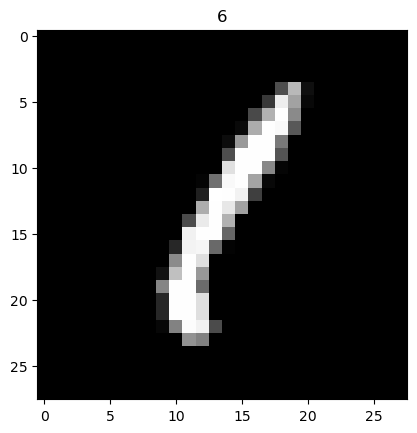

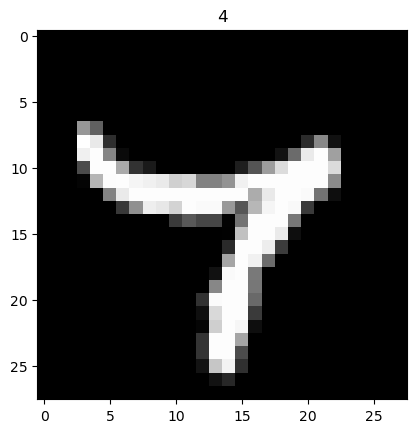

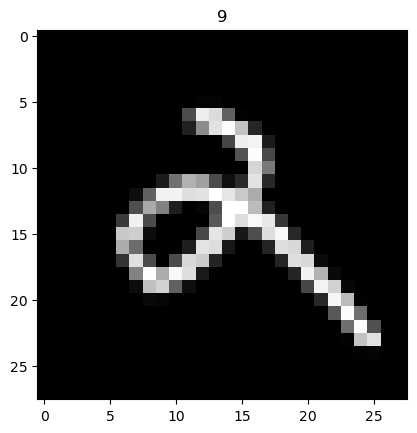

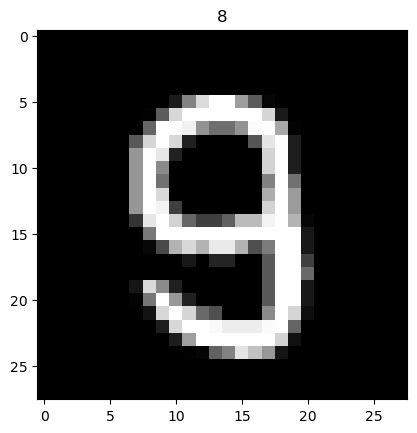

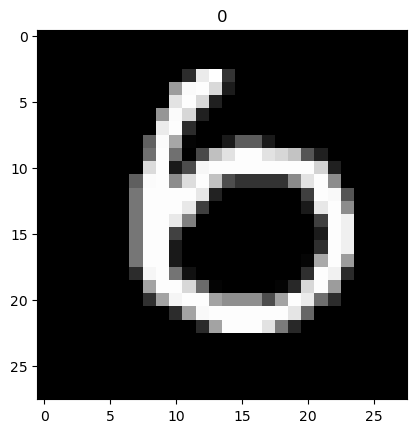

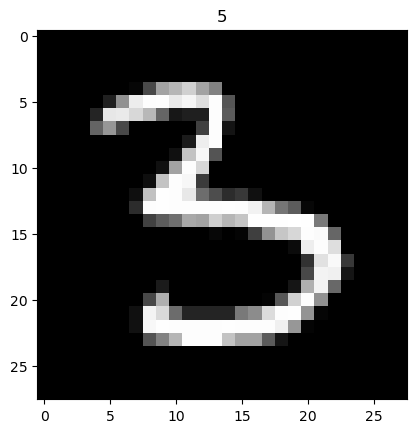

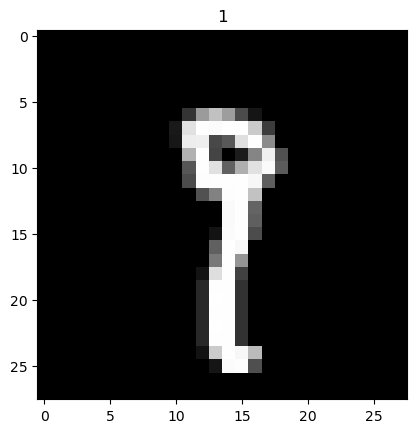

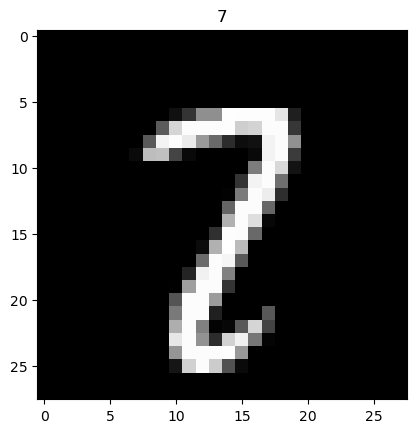

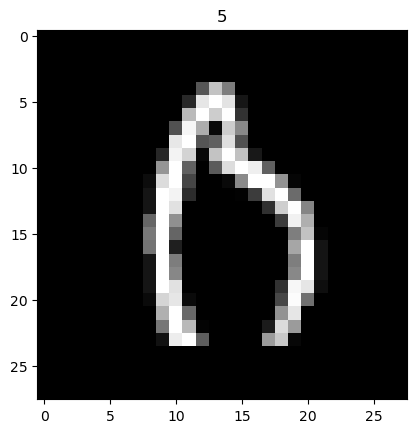

In [18]:
wrong_pred_index = (pred_test!=y_test)
wrong_preds = (X_test[wrong_pred_index], pred_test[wrong_pred_index])
wrong_preds[0].size()
for i in range(10): # 10 instances which the model predicted wrongly
    show_img(wrong_preds[0][i], wrong_preds[1][i])